# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.layers import Reshape, Flatten, Input, concatenate, Embedding, Conv1D
from tensorflow.keras.layers import RNN, LSTM, GRU, Dense, Embedding, Input, BatchNormalization, LeakyReLU, Dropout, ReLU
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.utils import CustomObjectScope

print(tf.__version__)

2.2.0


In [2]:
np.random.seed(1998)
random.seed(1998)
tf.random.set_seed(1998)

# Load Data

In [3]:
data = pd.read_csv('data/기상병합_data3.csv')
testdata = pd.read_csv('data/test_기상병합.csv')

print(data.shape)
print(testdata.shape)

(342732, 18)
(3539, 17)


## Preprocessing

In [4]:
# 학습에 필요없는 열 제거
train = data.drop(['plant_train.mea_ddhr', 'plant_train.plant', 'plant_train.loc', 
                      'plant_train.cond_loc', 'plant_test.x24h_tma', 'plant_train.x24h_cond_loc',
                      'plant_test.x48h_tma', 'plant_train.x48h_cond_loc'], axis = 1)
test = testdata.drop(['plant_test.mea_ddhr', 'plant_test.plant', 'plant_test.loc',
                      'plant_test.x24h_tma', 'plant_test.x24h_cond_loc',
                      'plant_test.x48h_tma', 'plant_test.x48h_cond_loc'], axis = 1)

# 학습에 사용할 조건을 분리(0 부터 시작해야 to_categorical 함수가 제대로 작동함)
train_con1 = np.array(data.loc[:,'plant_train.plant'])-1
train_con2 = np.array(data.loc[:,'plant_train.loc'])-1

test_con1 = np.array(testdata.loc[:,'plant_test.plant'])-1
test_con2 = np.array(testdata.loc[:,'plant_test.loc'])-1

# target 분리
train_label_24 = np.array(data.loc[:,'plant_train.x24h_cond_loc'])
train_label_48 = np.array(data.loc[:,'plant_train.x48h_cond_loc'])

In [5]:
# 조건을 one-hot encoding
train_con1 = tf.keras.utils.to_categorical(train_con1, num_classes=2)
train_con2 = tf.keras.utils.to_categorical(train_con2, num_classes=3)

test_con1 = tf.keras.utils.to_categorical(test_con1, num_classes=2)
test_con2 = tf.keras.utils.to_categorical(test_con2, num_classes=3)

print(train_con1.shape)
print(train_con2.shape)
print(test_con1.shape)
print(test_con2.shape)

(342732, 2)
(342732, 3)
(3539, 2)
(3539, 3)


In [6]:
# 입력 데이터를 사용할 모델에 맞게 차원을 추가
train = np.reshape(np.array(train), [train.shape[0], 1, train.shape[1]])
test = np.reshape(np.array(test), [test.shape[0], 1, test.shape[1]])

train_con1 = np.reshape(train_con1, [train_con1.shape[0], 1, train_con1.shape[1]])
train_con2 = np.reshape(train_con2, [train_con2.shape[0], 1, train_con2.shape[1]])

test_con1 = np.reshape(test_con1, [test_con1.shape[0], 1, test_con1.shape[1]])
test_con2 = np.reshape(test_con2, [test_con2.shape[0], 1, test_con2.shape[1]])

print(train.shape)
print(test.shape)
print(train_con1.shape)
print(train_con2.shape)
print(test_con1.shape)
print(test_con2.shape)

(342732, 1, 10)
(3539, 1, 10)
(342732, 1, 2)
(342732, 1, 3)
(3539, 1, 2)
(3539, 1, 3)


# Modeling

## Define Model

In [7]:
input_data = Input(shape = (None, train.shape[2]), name = 'X_data')
input_con1 = Input(shape = (None, 2), name = 'con1')
input_con2 = Input(shape = (None, 3,), name = 'con2')

x = concatenate([input_data, input_con1, input_con2])
x = LSTM(512, return_sequences = True, activation = 'tanh')(x)
x = LSTM(256, return_sequences = True, activation = 'tanh')(x)
x = LSTM(128, return_sequences = False, activation = 'tanh')(x)

#x = Dropout(0.1)(x)

x = Dense(64, activation = 'relu')(x)
x_out1 = Dense(1, activation = 'sigmoid', name = '24hour')(x)
x_out2 = Dense(1, activation = 'sigmoid', name = '48hour')(x)

model = Model([input_data, input_con1, input_con2], [x_out1, x_out2])

## Model Summary

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_data (InputLayer)             [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
con1 (InputLayer)               [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
con2 (InputLayer)               [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 15)     0           X_data[0][0]                     
                                                                 con1[0][0]                   

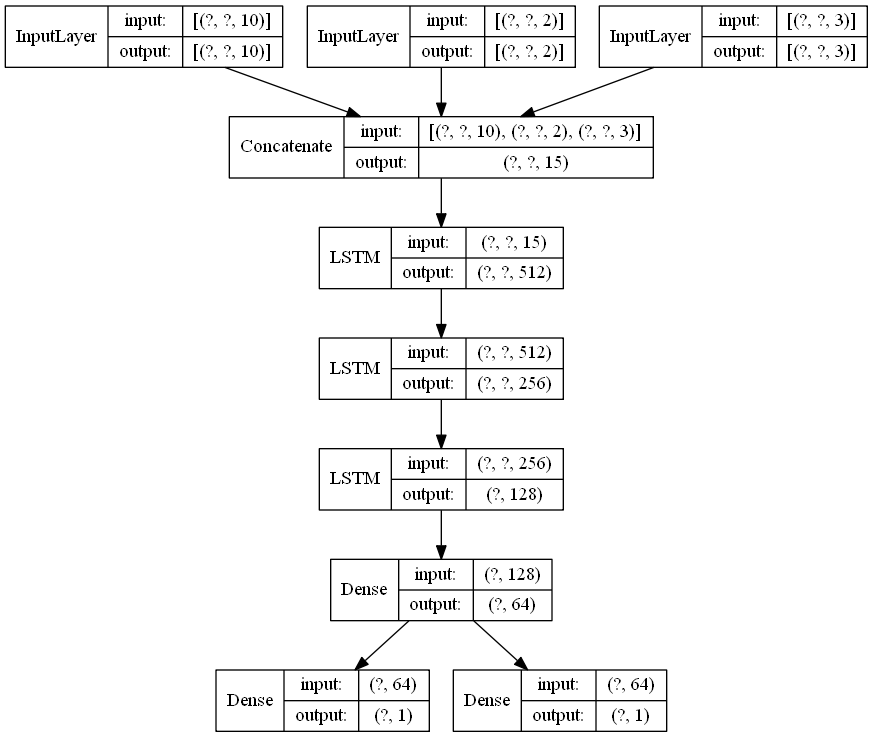

In [8]:
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=False)

## Fitting

In [9]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit([train, train_con1, train_con2], [train_label_24, train_label_48],
                    epochs = 30, 
                    batch_size = 128,
                    validation_split= 0.3)

### Ending Music

In [11]:
import winsound 
def main(): # 도,레,미,파,솔,라,시 Hz
    so1 = {'do':261,'re':293,'mi':329,'pa':349,'sol':391,'ra':440,'si':493} 
    mel = ['do','mi','mi', 'mi','sol','sol', 're','pa','pa','ra','si','si'] 
    dur = [4,4,2, 4,4,2, 4,4,2, 4,4,2]
    mel2 = ['sol','do','ra','pa','mi','do','re']
    dur2 = [1,1,1,1,1,1,1]
    music = zip(mel,dur)
    music2 = zip(mel2,dur2) 
    for melody,duration in music: winsound.Beep(so1[melody],1000//duration)
    for melody,duration in music2: winsound.Beep(so1[melody],1000//duration) 
        
        
if __name__ == '__main__': main()

## Graph

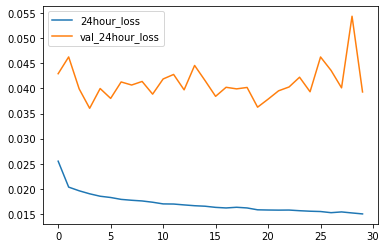

In [13]:
plt.plot(history.history['24hour_loss'], label = '24hour_loss')
plt.plot(history.history['val_24hour_loss'], label = 'val_24hour_loss')

plt.legend()

plt.show()

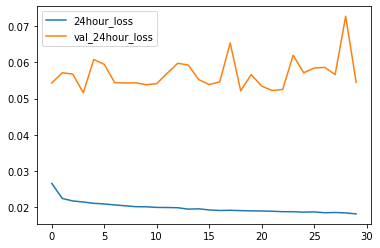

In [14]:
plt.plot(history.history['48hour_loss'], label = '24hour_loss')
plt.plot(history.history['val_48hour_loss'], label = 'val_24hour_loss')

plt.legend()

plt.show()

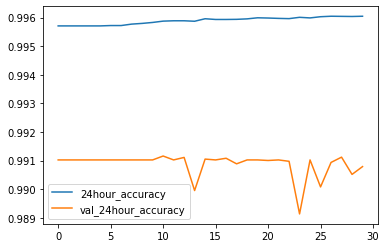

In [15]:
plt.plot(history.history['24hour_accuracy'], label = '24hour_accuracy')
plt.plot(history.history['val_24hour_accuracy'], label = 'val_24hour_accuracy')

plt.legend()

plt.show()

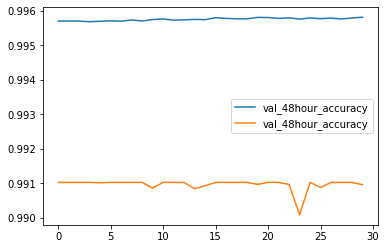

In [16]:
plt.plot(history.history['48hour_accuracy'], label = 'val_48hour_accuracy')
plt.plot(history.history['val_48hour_accuracy'], label = 'val_48hour_accuracy')

plt.legend()

plt.show()

## Save Model

In [17]:
# Json파일로 가중치를 빼고 모델 아키텍처만 저장
model_json = model.to_json()
with open("Model/model.json", "w") as json_file : 
    json_file.write(model_json)

# End